# Notebook Clustering

This notebook is devoted to identifying communities of Jupyter Notebook users, using the import statements in python notebooks to find clusters of python libraries. While this did not make it into the final paper, it shows the potential of clustering communities of notebooks and notebook users based on the unique libraries they import.

In [1]:
import re
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

## 0. Load Data

In [3]:
df_nbs = pd.read_csv('../data/csv/nb_metadata.csv')
df_cells = pd.read_csv('../data/csv/cell_metadata.csv')

## 1. Get list of imports for every python notebook

In [4]:
# trim list of imports to only unique items
def return_unique(vals):
    imports = []
    for v in vals:
        val_array = ast.literal_eval(v)
        imports += val_array
    return list(set(imports))


# get cells with import statements
df_cells_w_imports = df_cells[df_cells.num_imports > 0]

# aggregate imports by notebook
imports_by_nb = df_cells_w_imports[
        ['nb_id',
        'num_imports',
        'imports']
    ].groupby('nb_id').agg(
        {'num_imports': np.sum, 
         'imports': lambda s: return_unique(s)}
    )

# get ids of all notebooks in python
python_nb_ids = df_nbs[df_nbs.lang_name == 'python']['nb_id']

# filter list of notebooks with imports to only those written in python
imports_by_nb_python = imports_by_nb[imports_by_nb.index.isin(python_nb_ids)]

print('%s cells with imports in them' % df_cells_w_imports.shape[0])
print('%s notebooks with imports in them' % imports_by_nb.shape[0])
print('%s notebooks written in python' % python_nb_ids.shape[0])
print('%s notebooks with imports written in python with imports' % imports_by_nb_python.shape[0])

imports_by_nb_python.head()

2526213 cells with imports in them
919192 notebooks with imports in them
1014894 notebooks written in python
898733 notebooks with imports written in python with imports


,num_imports,imports
nb_id,,
585,4,"[scipy.signal, scipy.fftpack, IPython.display,..."
586,3,"[matplotlib, JSAnimation.IPython_display, IPyt..."
587,23,"[matplotlib, keras.utils.visualize_util, keras..."
588,16,"[scipy.cluster.vq, numpy, IPython, math, libro..."
589,7,"[numpy, pickle, tensorflow, os, matplotlib.pyp..."


## 2. Clean Import Names and ignore sub-modules
Looking at the data above, some import names need cleaning (e.g., trailing commas on import names) and we may only want to look at the major package names.

In [5]:
# convert full import names to only list of major packages
def clean_import_names(import_list):
    clean_imports = [re.split('[,;:]+', x)[0] for x in import_list]
    return list(set(clean_imports))

def get_major_packages(import_list):
    major_imports = [re.split('[.]+', x)[0] for x in import_list]
    return list(set(major_imports))

# clean the main import list, and make new list of only full modules
imports_by_nb_python['imports'] = imports_by_nb_python['imports'].apply(lambda x: clean_import_names(x))
imports_by_nb_python['imports_major'] = imports_by_nb_python['imports'].apply(lambda x: get_major_packages(x))
imports_by_nb_python.head()

/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,num_imports,imports,imports_major
nb_id,,,
585,4,"[scipy.fftpack, scipy.signal, IPython.display,...","[scipy, IPython]"
586,3,"[matplotlib, JSAnimation.IPython_display, IPyt...","[matplotlib, JSAnimation, IPython]"
587,23,"[matplotlib, keras.utils.visualize_util, keras...","[copy, numpy, matplotlib, pickle, time, os, pr..."
588,16,"[scipy.cluster.vq, numpy, IPython, math, libro...","[numpy, IPython, matplotlib, math, sklearn, li..."
589,7,"[numpy, pickle, tensorflow, os, matplotlib.pyp...","[numpy, matplotlib, pickle, tensorflow, os, sc..."


## 3. Import counts across all notebooks

4333569 major imports across all notebooks
42647 different major libraries imported

Percent of all imports accounted for by
Top 3: 34.84580392524679
Top 10: 56.250803104556006
Top 20: 69.7681900250897
Top 100: 89.07111871878443
Top 1000: 96.69986165498159


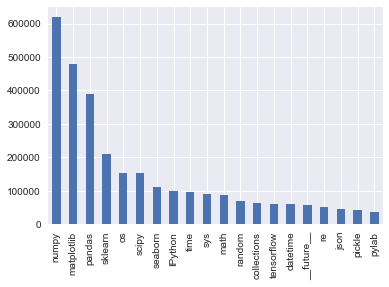

In [6]:
major_imports = pd.Series([item for sublist in imports_by_nb_python.imports_major for item in sublist])
major_import_counts = major_imports.value_counts()

print('%s major imports across all notebooks' %  major_imports.shape[0])
print('%s different major libraries imported' %  major_import_counts.shape)
print("")
print("Percent of all imports accounted for by")
print('Top 3: %s' % str(major_import_counts.head(3).sum() / major_import_counts.shape[0]))
print('Top 10: %s' %  str(major_import_counts.head(10).sum() / major_import_counts.shape[0]))
print('Top 20: %s' %  str(major_import_counts.head(20).sum() / major_import_counts.shape[0]))
print('Top 100: %s' %  str(major_import_counts.head(100).sum() / major_import_counts.shape[0]))
print('Top 1000: %s' %  str(major_import_counts.head(1000).sum() / major_import_counts.shape[0]))

major_import_counts.head(20).plot(kind='bar')

## 4. Generate import co-occurance matrix for top imports

For the sake of this analysis, we are only considering modules that are imported in 0.1% or more of the ~900k python notebooks in our sample. If we find usefull results there, we may extend the analysis to look at all modules. All other modules will be tracked as 'other'.

In [11]:
import_threshold = int(imports_by_nb_python.shape[0] * 0.001)
top_imports = list(major_import_counts[major_import_counts > import_threshold].index)
print("Analyzing the top %s imports, which have each been imported into our sample or at least %s times" % (len(top_imports), import_threshold))

# filter list on only modules in our top modules list
def get_major_top_packages(import_list):
    major_top_imports = [x if x in top_imports else 'other' for x in import_list]
    return list(set(major_top_imports))

# create new column with only top imports
imports_by_nb_python['imports_major_top'] = imports_by_nb_python['imports_major'].apply(lambda x: get_major_top_packages(x))
imports_by_nb_python.head()

Analyzing the top 183 imports, which have each been imported into our sample or at least 898 times


/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,num_imports,imports,imports_major,imports_major_top
nb_id,,,,
585,4,"[IPython, scipy.fftpack, scipy.signal, IPython...","[scipy, IPython]","[scipy, IPython]"
586,3,"[JSAnimation.IPython_display, IPython.display,...","[JSAnimation, matplotlib, IPython]","[JSAnimation, matplotlib, IPython]"
587,23,"[keras.utils, keras.datasets, pylab, numpy, pr...","[numpy, processing, pickle, os, keras, time, p...","[numpy, processing, pickle, os, keras, time, p..."
588,16,"[numpy, matplotlib.pyplot, IPython, math, libr...","[numpy, math, librosa, sklearn, scipy, sys, IP...","[numpy, IPython, math, sklearn, other, scipy, ..."
589,7,"[numpy, matplotlib.pyplot, tensorflow, pickle,...","[numpy, tensorflow, pickle, os, scipy, fish_da...","[numpy, tensorflow, pickle, os, other, scipy, ..."


In [12]:
# turn list of imports for each notebook into table with 0s and 1s for each import
df_top_major_imports_dummy = pd.get_dummies(
    imports_by_nb_python.imports_major_top.apply(pd.Series).stack()
).sum(level=0)

df_int = df_top_major_imports_dummy.astype(int)
import_cooc = df_int.T.dot(df_int)

import_cooc.head()

,Bio,Eigen_decomp,IPython,Image,JSAnimation,MySQLdb,PIL,ROOT,StringIO,YearPlotter,...,warnings,webbrowser,window,wordcloud,xarray,xgboost,xlrd,xml,yaml,zipfile
Bio,2419,0,351,0,3,0,6,0,23,0,...,70,1,0,2,0,12,1,26,9,14
Eigen_decomp,0,1264,1,0,0,0,0,0,0,1260,...,0,0,0,0,0,0,0,0,0,0
IPython,351,1,99454,93,261,77,3736,155,609,2,...,4109,113,12,293,121,977,90,257,210,505
Image,0,0,93,1043,0,0,150,0,7,0,...,24,0,0,2,0,0,3,2,2,6
JSAnimation,3,0,261,0,934,0,6,0,0,0,...,28,0,0,0,0,0,1,0,2,0


## 5. Plot Clusters of Co-occuring imports

/Users/doug/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


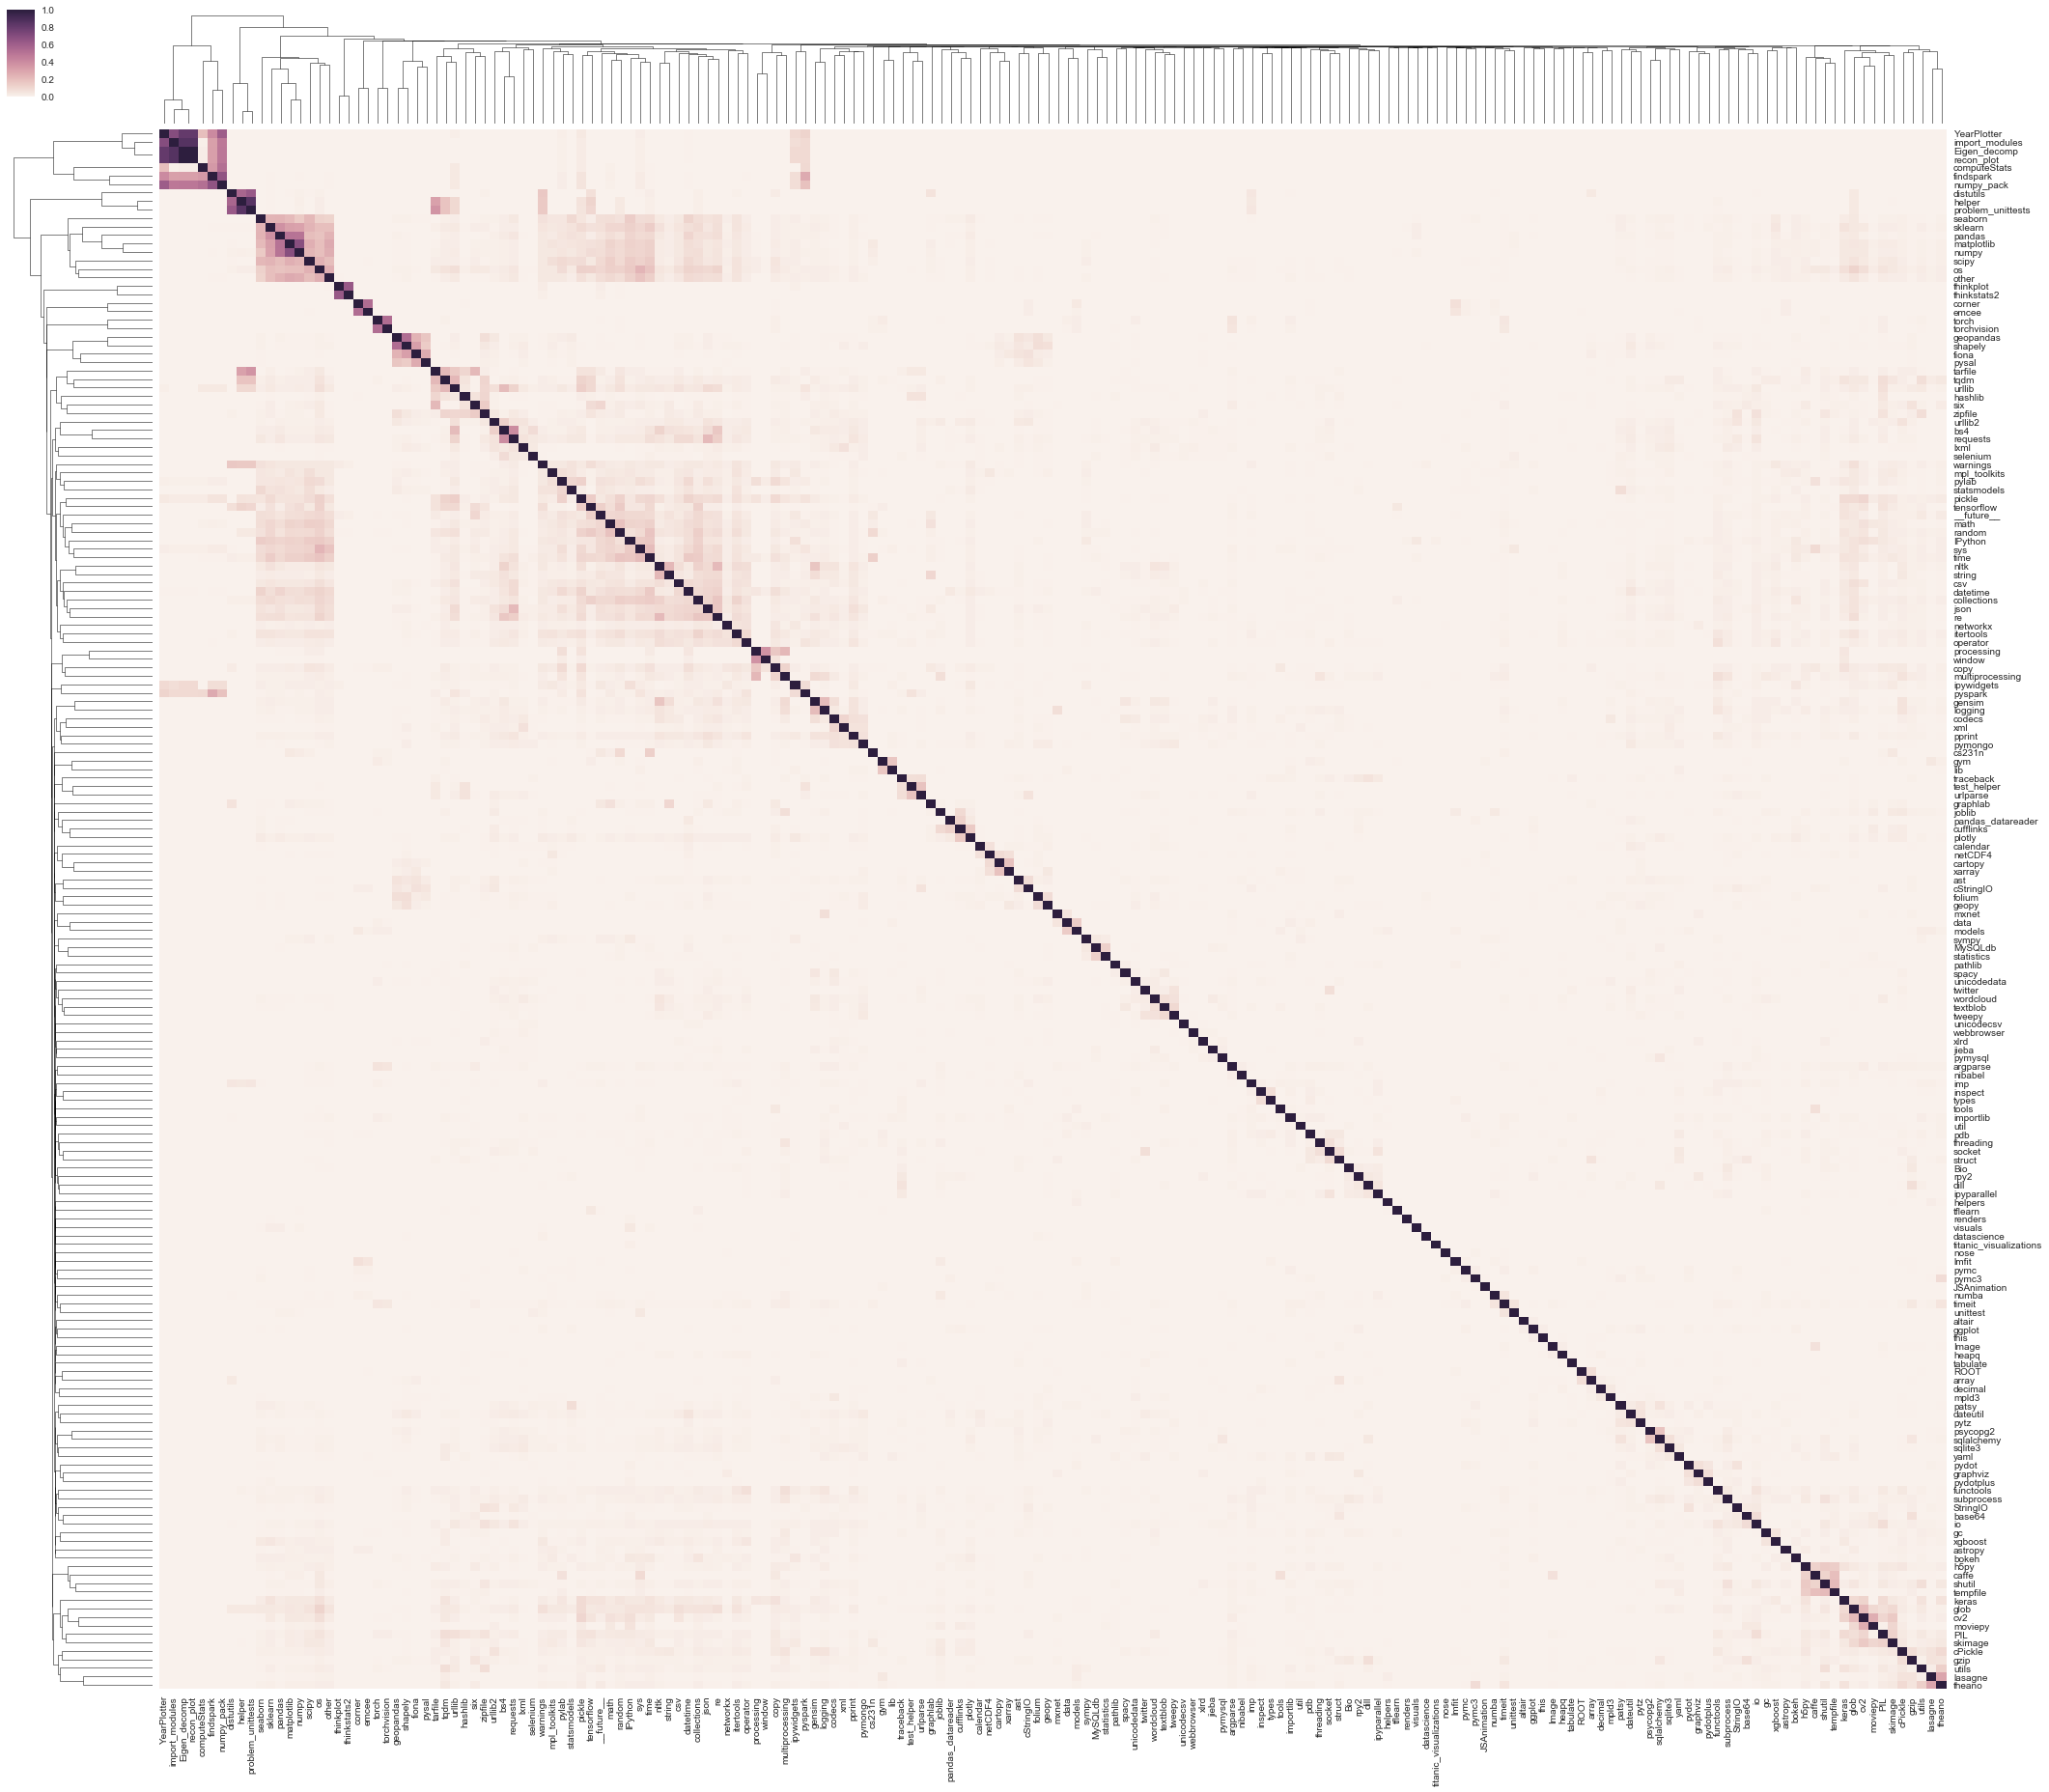

In [15]:
# normalize co-occurance counts based on max num times either import appears
import_cooc_float = np.array(import_cooc).astype(float)
import_cooc_norm = np.empty_like(import_cooc_float)
for i, row in enumerate(import_cooc_float):
    for j, val in enumerate(row):
        norm_factor = max(import_cooc_float[i,i], import_cooc_float[j,j])
        import_cooc_norm[i,j] = float(float(val) / float(norm_factor))

# relabel the dataframe
df_import_cooc_norm = pd.DataFrame(import_cooc_norm)
df_import_cooc_norm.index = import_cooc.columns
df_import_cooc_norm.columns = import_cooc.columns

# generate clusters
g = sns.clustermap(df_import_cooc_norm, figsize=(36,32))
p = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

## 6. Discussion

The main clusters seem to be the following ids:
- 0-3
- 0-6
- 7-9
- 10-17
- 18-19
- 20-21
- 22-23
- 24-27
- 35-36
- -1-2
- -6-11
- -12-15

We can look at these in turn.

In [33]:
clusters = [
    [0,7],
    [7,10],
    [10,18],
    [18,20],
    [20,22],
    [22,24],
    [24,28],
    [35,37],
    [-15,-11],
    [-11,-5],
    [-2,None]    
]

for i, c in enumerate(clusters):
    indicies = g.dendrogram_row.reordered_ind[c[0]: c[1]]
    packages = [df_import_cooc_norm.columns[j] for j in indicies]
    print("Cluster %s:" % i)
    print(packages)
    print('')

Cluster 0:
['YearPlotter', 'import_modules', 'Eigen_decomp', 'recon_plot', 'computeStats', 'findspark', 'numpy_pack']

Cluster 1:
['distutils', 'helper', 'problem_unittests']

Cluster 2:
['seaborn', 'sklearn', 'pandas', 'matplotlib', 'numpy', 'scipy', 'os', 'other']

Cluster 3:
['thinkplot', 'thinkstats2']

Cluster 4:
['corner', 'emcee']

Cluster 5:
['torch', 'torchvision']

Cluster 6:
['geopandas', 'shapely', 'fiona', 'pysal']

Cluster 7:
['bs4', 'requests']

Cluster 8:
['h5py', 'caffe', 'shutil', 'tempfile']

Cluster 9:
['keras', 'glob', 'cv2', 'moviepy', 'PIL', 'skimage']

Cluster 10:
['lasagne', 'theano']



After some research on the names, it seems some of these, like Cluster 0, are simply packages that people wrote themselves. Others represent distinct groups.

Cluster 2 is what we may call the standard pack: basic numerical computing libraries that lots of people use.

Cluster 6 is for GIS processing

Cluster 7 is for web scraping

Cluster 9 is computer vision

Clusters 5, 8, and 10 all seem to be machine learning varints with torch, caffee, and theano at their core

Cluster 3 is a set of libraries for a popular book, Think Stats

Cluster 4 is a set of packages for Markov Chains

If we did a cleaner analyses or a deeper analysis we could find other groups (the sqlite group) but I don't think these will be as fruitful.